In [1]:
import os
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

from src.data import blend
from src.models import PretrainedUNet
from src.metrics import jaccard, dice

In [2]:
data_folder = Path("data")
models_folder = Path("models")
data_description = pd.read_csv(data_folder / "train.csv")

In [3]:
splits = {}
splits["train"], splits["test"] = train_test_split(data_description, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

splits["train"] = splits["train"].reset_index(drop=True)
splits["test"] = splits["test"].reset_index(drop=True)
splits["val"] = splits["val"].reset_index(drop=True)

In [16]:
class HumanSegmentDataset(torch.utils.data.Dataset):
    def __init__(self, description, data_folder, transfrom=None):
        self.description = description
        self.data_folder = data_folder
        self.transfrom = transfrom
        
        
    def __getitem__(self, idx):
        try:
            origin_fn = self.data_folder / self.description.loc[idx, "origin"]
            mask_fn = self.data_folder / self.description.loc[idx, "mask"]

            print(origin_fn)
            print(mask_fn)
            
            origin = Image.open(origin_fn)
            if origin.mode != "RGB":
                origin = origin.convert("RGB")

            mask = Image.open(mask_fn)

            if self.transfrom is not None:
                transformed = self.transfrom(
                    image=np.array(origin),
                    mask=np.array(mask)
                )
                origin = transformed["image"]
                mask = transformed["mask"]

            origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
            mask = (torch.tensor(np.array(mask)) > 0).long() 

            return origin, mask
        except Exception as e:
            
            print(f"current idx: {idx}", e)
            return torch.zeros((3, 512, 512)), torch.zeros((512, 512)).long()
        
    def __len__(self):
        return len(self.description)

In [17]:
batch_size = 4

train_transforms = A.Compose([
    A.ShiftScaleRotate(scale_limit=0.02, rotate_limit=0, border_mode=0, value=0),
    A.Resize(512, 512),
    A.HorizontalFlip(),
])

test_val_transforms = A.Compose([
    A.Resize(512, 512),
])


datasets = {mode: HumanSegmentDataset(
    splits[mode],
    data_folder,
    train_transforms if mode == "train" else test_val_transforms
) for mode in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], 
    batch_size=batch_size
) for x in ["train", "test", "val"]}

data/LIP_data/train_images/406187_426445.jpg
data/LIP_data/annotations/406187_426445.png
loading time: 0.1830737590789795


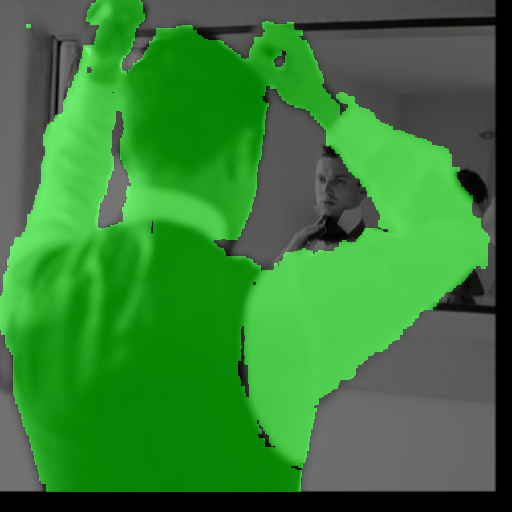

In [42]:
start_t = time.time()

image, mask = datasets["train"][20]


end_t = time.time()
print(f"loading time: {end_t - start_t}")

blend(image+0.5, mask)

In [32]:
data_description.origin.apply(lambda o: "LV" in o).sum()

20403

In [ ]:
img_sizes = []
for origin, mask in tqdm(dataloaders["train"]):
    img_sizes.append(origin.size())


# mean width and height
print(np.mean(list(map(lambda s: s[2], img_sizes))))
print(np.mean(list(map(lambda s: s[3], img_sizes))))

### Different range of pixels in different datasets
cause of PIL version mismatch

In [9]:
import PIL
PIL.__version__

'6.0.0'

In [10]:
import matplotlib
matplotlib.__version__

'3.1.0'

P
[0 1]


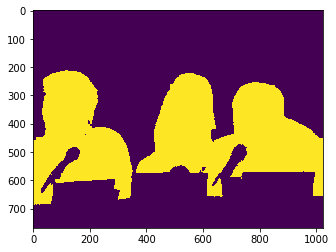

In [7]:
img1 = Image.open("data/LV-MHP-v2/val/masks/17737.png")
print(img1.mode)
print(np.unique(np.array(img1)))

plt.imshow(img1)

P
[  0 255]


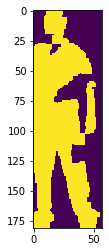

In [8]:
img2 = Image.open("data/LIP_data/annotations/73093_518573.png")
print(img2.mode)
print(np.unique(np.array(img2)))
plt.imshow(img2)